In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects

# DataSet
class SplashDataSet_v2(Dataset):
    def __init__(self, root_dir, train=True, train_size = 5, test_size=10):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # split DataSet for (train, validation) and (test)
        train_imgs, test_imgs, train_masks, test_masks = train_test_split(
            self.images_list, self.masks_list, train_size=train_size, test_size=test_size, random_state=42)

        if train:
            # train + validation dataset, split by Subset
            self.images = train_imgs
            self.masks = train_masks
        else:
            # test dataset
            self.images = test_imgs
            self.masks = test_masks

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # 總損失為原始損失加上蒸餾損失
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss

    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0418test_from0_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)
#model_segformer.load_state_dict(torch.load('weights_KD_segformer_0409test_90\segformer_data_size_200.pth'))
"""
# Student Model: Segformer
model_name = "nvidia/mit-b0"
config = SegformerConfig.from_pretrained(model_name)
config.num_labels = 2
model_segformer = SegformerForSemanticSegmentation.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
image_processor_segformer = SegformerImageProcessor.from_pretrained(model_name)
"""
# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300, 340, 350]
#train_sizes = [50, 200, 340]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()
for train_size in train_sizes:
    train_val_dataset = SplashDataSet_v2(root_dir=root_dir, train_size=train_size, train=True)
    test_dataset = SplashDataSet_v2(root_dir=root_dir, train_size=train_size, train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    # Apply K-fold
    kfold = KFold(n_splits=5, shuffle=True)
    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_index, val_index) in enumerate(kfold.split(train_val_dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        # 分割 train & validation
        train_subset = Subset(train_val_dataset, train_index)
        val_subset = Subset(train_val_dataset, val_index)
        # DataLoader
        train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 9s 780ms/step - loss: 0.3281
Average validation loss: 0.6519548892974854
4/4 [==============================] - 9s 800ms/step - loss: 0.3281 - val_loss: 0.6520
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0418test_from0_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 768ms/step - loss: 0.2741 - val_loss: 0.6520
Average validation loss: 0.4750322103500366
4/4 [==============================] - 12s 790ms/step - loss: 0.2741 - val_loss: 0.5635
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0418test_from0_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 770ms/step - loss: 0.2233 - val_loss: 0.5635
Average validation loss: 0.34283703565597534
4/4 [==============================] - 15s 786ms/step - loss: 0.2233 - val_loss: 0.4899
Saved model weights to 'c:\Users\user\Desktop\天_

train_size size =  20
mean_val_losses size =  20
std_val_losses size =  20
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300, 340, 350]
mean_val_losses =  [0.3539333461084786, 0.42508565322766634, 0.3808878254228349, 0.13564451659930113, 0.07915863199375439, 0.07750741912666048, 0.03269497892481188, 0.01868254569314298, 0.01429294758305679, 0.011941314669132374, 0.008782443860296987, 0.007361914254024233, 0.009326347265196428, 0.00901326668682733, 0.010862293395141009, 0.009139732934274754, 0.007988469556819448, 0.007121434133465633, 0.007161463478352843, 0.004669910385220687]
std_val_losses =  [0.5017182610812622, 0.4048881971472016, 0.39099607044581114, 0.10238035453559997, 0.06602795427884599, 0.09693747328392432, 0.019133068333066463, 0.015958532375908874, 0.011091292822547984, 0.013498976593293452, 0.0049426109819895505, 0.0056723346316746, 0.008768967159547763, 0.006599451790731186, 0.010658715315496064, 0.01335257519854809, 0.00450447677

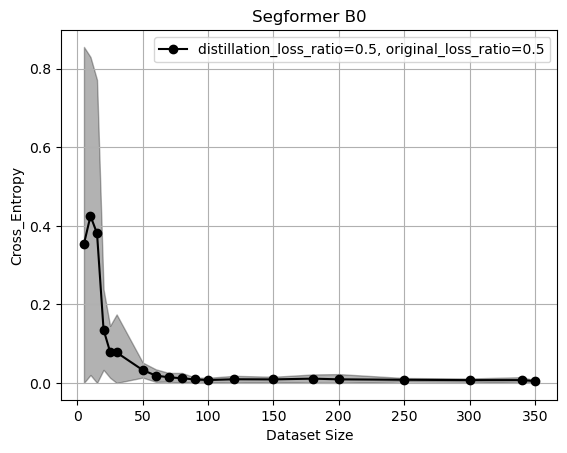

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
def test_model_and_visualize(model, image_processor, test_loader, num_visualizations=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(f'weights_KD_segformer_0418test_from0_{round(teacher_ratio*100)}\segformer_data_size_350.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    iou_scores = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    with torch.no_grad():
        for idx, (image, mask) in enumerate(test_loader):
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)
            pred_mask = outputs.argmax(dim=1)

            # Compute loss
            loss = criterion(outputs, mask.squeeze(1).long())
            total_loss += loss.item()

            # Convert to binary format for evaluation
            mask_np = mask.cpu().numpy().squeeze(1)
            pred_mask_np = pred_mask.cpu().numpy()

            # Flatten the arrays for comparison
            true_flat = mask_np.flatten()
            pred_flat = pred_mask_np.flatten()

            # Calculate metrics
            iou_scores.append(jaccard_score(true_flat, pred_flat, average='binary', zero_division=0))
            accuracies.append(accuracy_score(true_flat, pred_flat))
            precisions.append(precision_score(true_flat, pred_flat, average='binary', zero_division=0))
            recalls.append(recall_score(true_flat, pred_flat, average='binary', zero_division=0))
            f1_scores.append(f1_score(true_flat, pred_flat, average='binary', zero_division=0))


            if idx < num_visualizations:
                # Visualize results
                showSegmentationResult(model, image_processor, [(image, mask)], num_images=1)

    avg_loss = total_loss / len(test_loader)
    avg_iou = np.mean(iou_scores)
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    print(f"Average test loss: {avg_loss}")
    print(f"Average IoU: {avg_iou}")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1 Score: {avg_f1}")

    return avg_loss, avg_iou, avg_accuracy, avg_precision, avg_recall, avg_f1

# test_model_and_visualize(model_segformer, image_processor_segformer, test_loader, num_visualizations=3)
def extract_number(filename):
    return int(filename.split('_')[-1].split('.')[0])

def test_model_and_visualize_2(model, test_loader, weight_dir, num_visualizations=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_avg_metrics = []

    weight_files = sorted(os.listdir(weight_dir), key=extract_number)
    for weight_file in weight_files:
        print("[test] weight_file = ", weight_file)
        model.load_state_dict(torch.load(os.path.join(weight_dir, weight_file)))
        model.eval()

        total_loss = 0.0
        iou_scores = []
        accuracies = []
        precisions = []
        recalls = []
        f1_scores = []

        with torch.no_grad():
            for idx, (image, mask) in enumerate(test_loader):
                image, mask = image.to(device), mask.to(device)
                outputs = model(image)
                pred_mask = outputs['out'].argmax(dim=1)

                # Compute loss
                loss = criterion(outputs['out'], mask.squeeze(1).long())
                total_loss += loss.item()

                # Convert to binary format for evaluation
                mask_np = mask.cpu().numpy().squeeze(1)
                pred_mask_np = pred_mask.cpu().numpy()

                # Flatten the arrays for comparison
                true_flat = mask_np.flatten()
                pred_flat = pred_mask_np.flatten()

                # Calculate metrics
                iou_scores.append(jaccard_score(true_flat, pred_flat, average='binary', zero_division=0))
                accuracies.append(accuracy_score(true_flat, pred_flat))
                precisions.append(precision_score(true_flat, pred_flat, average='binary', zero_division=0))
                recalls.append(recall_score(true_flat, pred_flat, average='binary', zero_division=0))
                f1_scores.append(f1_score(true_flat, pred_flat, average='binary', zero_division=0))

        avg_metric = {
            'loss': total_loss / len(test_loader),
            'iou': np.mean(iou_scores),
            'accuracy': np.mean(accuracies),    
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'f1': np.mean(f1_scores)
        }
        all_avg_metrics.append(avg_metric)
    return all_avg_metrics
weight_dir = f"weights_KD_segformer_0418test_from0_{round(teacher_ratio*100)}"
metric_test = test_model_and_visualize_2(model_segformer, test_loader, weight_dir, 3)

[test] weight_file =  segformer_data_size_5.pth
[test] weight_file =  segformer_data_size_10.pth
[test] weight_file =  segformer_data_size_15.pth
[test] weight_file =  segformer_data_size_20.pth
[test] weight_file =  segformer_data_size_25.pth
[test] weight_file =  segformer_data_size_30.pth
[test] weight_file =  segformer_data_size_50.pth
[test] weight_file =  segformer_data_size_60.pth
[test] weight_file =  segformer_data_size_70.pth
[test] weight_file =  segformer_data_size_80.pth
[test] weight_file =  segformer_data_size_90.pth
[test] weight_file =  segformer_data_size_100.pth
[test] weight_file =  segformer_data_size_120.pth
[test] weight_file =  segformer_data_size_150.pth
[test] weight_file =  segformer_data_size_180.pth
[test] weight_file =  segformer_data_size_200.pth
[test] weight_file =  segformer_data_size_250.pth
[test] weight_file =  segformer_data_size_300.pth
[test] weight_file =  segformer_data_size_340.pth
[test] weight_file =  segformer_data_size_350.pth


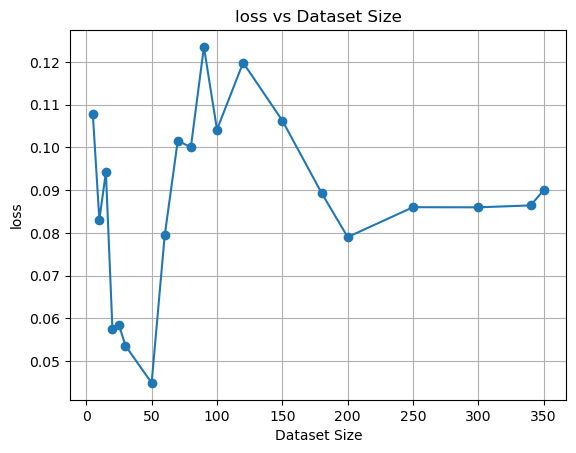

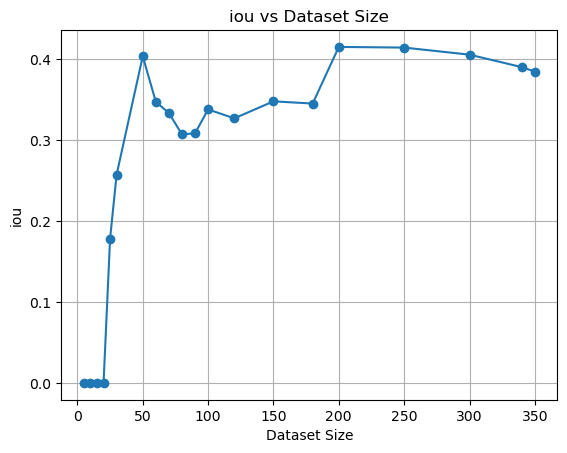

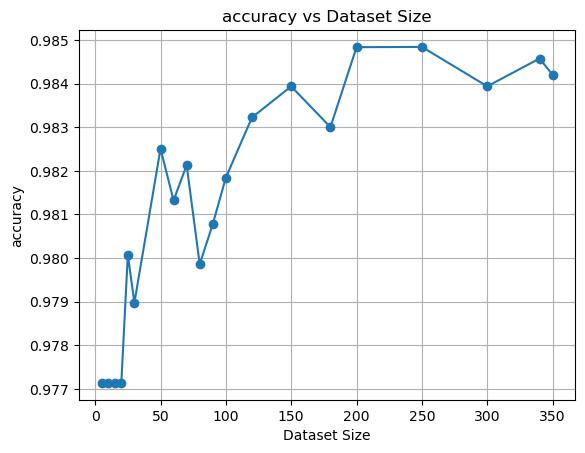

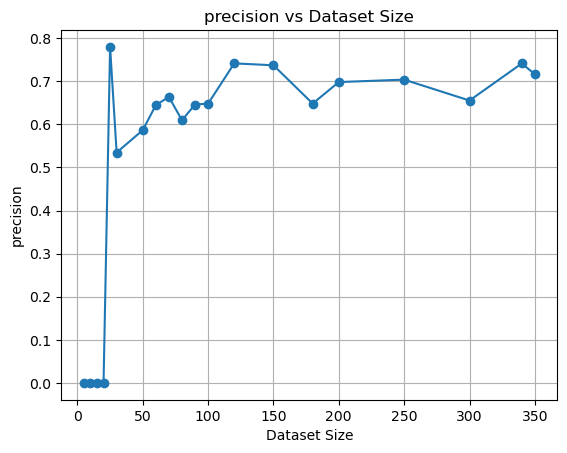

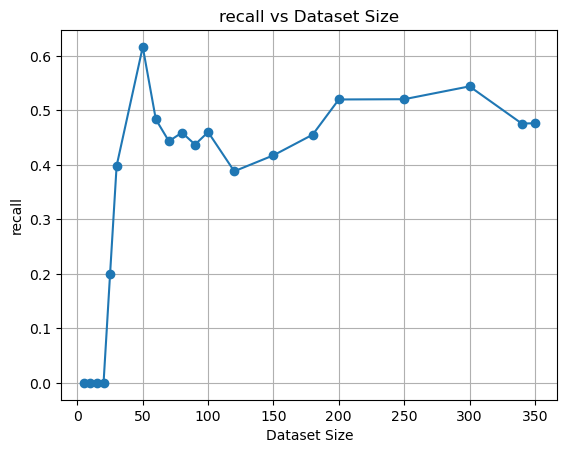

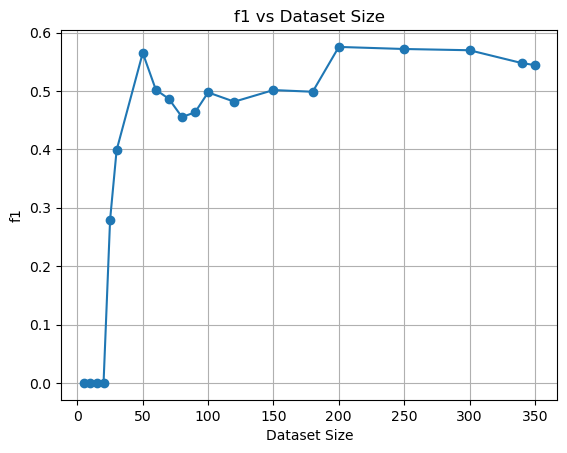

In [5]:
# 繪製圖表
metrics_keys = metric_test[0].keys()
for key in metrics_keys:
    plt.figure()
    metric_values = [metrics[key] for metrics in metric_test]
    plt.plot(train_sizes, metric_values, marker='o')
    plt.title(f'{key} vs Dataset Size')
    plt.xlabel('Dataset Size')
    plt.ylabel(key)
    plt.grid(True)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.09002528507262468,
 0.3847685787845388,
 0.9842008590698242,
 0.7163180212363709,
 0.47648585351436895,
 0.5441770852794515)

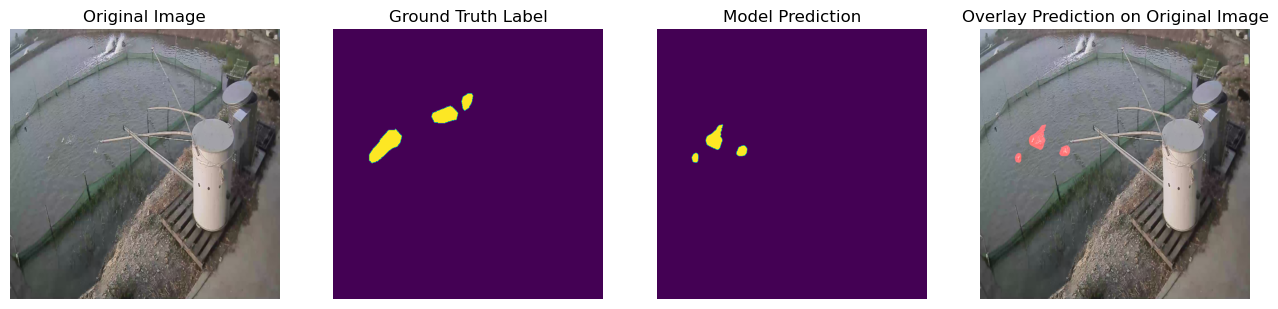

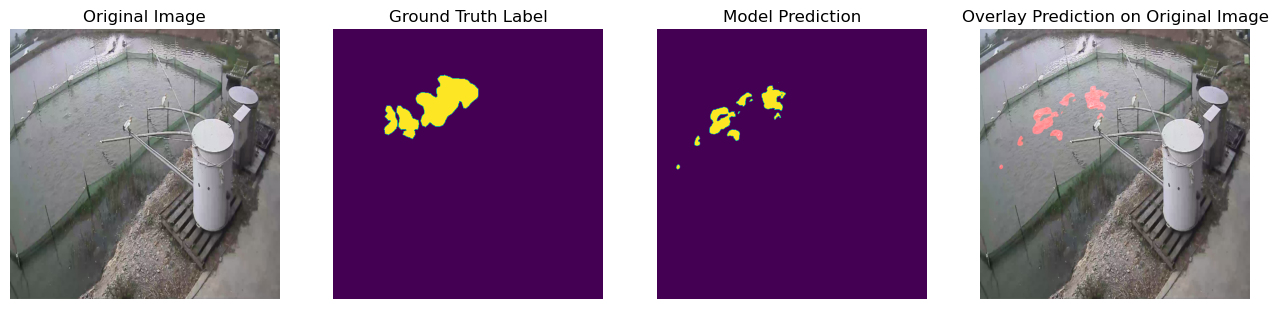

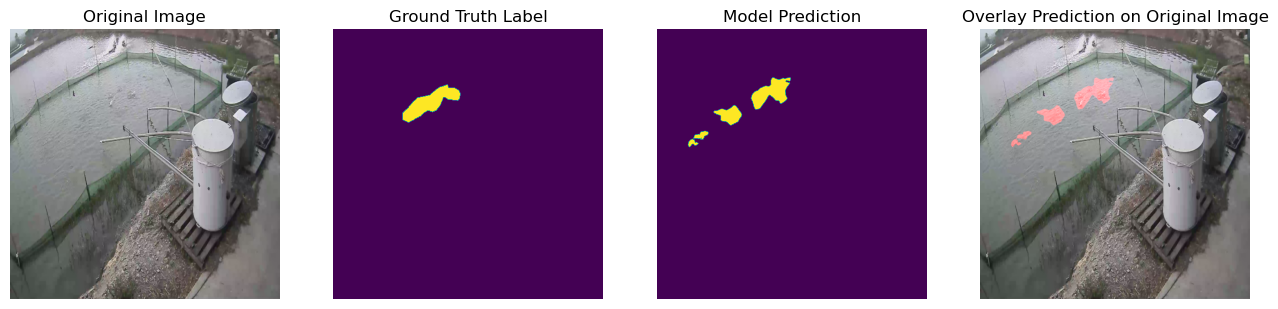

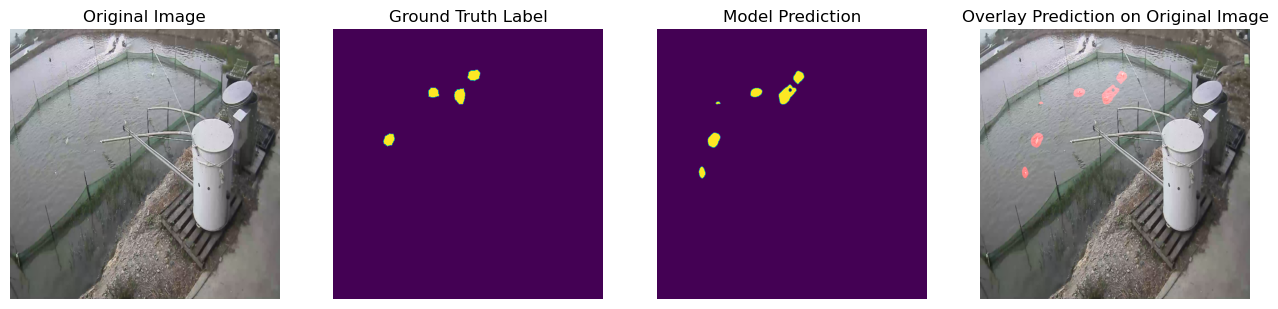

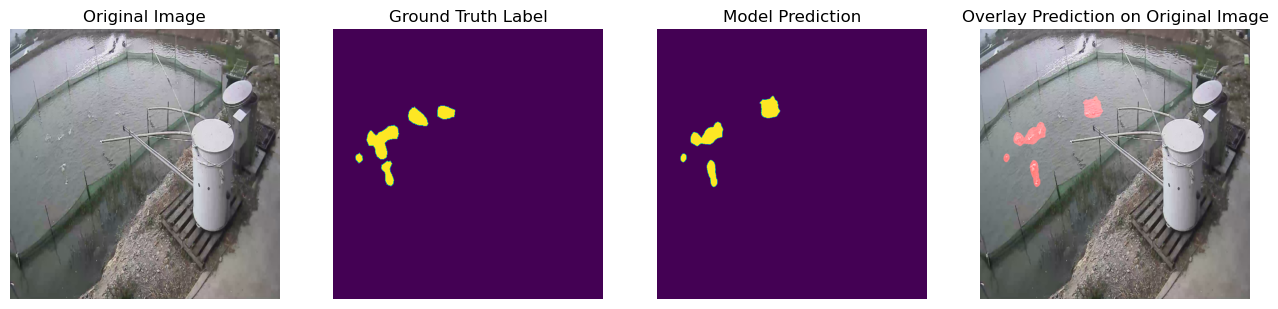

In [6]:
def test_model_and_visualize_9(model, test_loader, num_visualizations=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(f'weights_KD_segformer_0418test_from0_{round(teacher_ratio*100)}\segformer_data_size_350.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    iou_scores = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    with torch.no_grad():
        for idx, (image, mask) in enumerate(test_loader):
            image, mask = image.to(device), mask.to(device)
            outputs = model(image)
            pred_mask = outputs['out'].argmax(dim=1)

            # Compute loss
            loss = criterion(outputs['out'], mask.squeeze(1).long())
            total_loss += loss.item()

            # Convert to binary format for evaluation
            mask_np = mask.cpu().numpy().squeeze(1)
            pred_mask_np = pred_mask.cpu().numpy()

            # Flatten the arrays for comparison
            true_flat = mask_np.flatten()
            pred_flat = pred_mask_np.flatten()

            # Calculate metrics
            iou_scores.append(jaccard_score(true_flat, pred_flat, average='binary', zero_division=0))
            accuracies.append(accuracy_score(true_flat, pred_flat))
            precisions.append(precision_score(true_flat, pred_flat, average='binary', zero_division=0))
            recalls.append(recall_score(true_flat, pred_flat, average='binary', zero_division=0))
            f1_scores.append(f1_score(true_flat, pred_flat, average='binary', zero_division=0))


            if idx < num_visualizations:
                # Visualize results
                showSegmentationResult(model, [(image, mask)], num_images=1)

    avg_loss = total_loss / len(test_loader)
    avg_iou = np.mean(iou_scores)
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)


    return avg_loss, avg_iou, avg_accuracy, avg_precision, avg_recall, avg_f1

test_model_and_visualize_9(model_segformer, test_loader, 5)